In [31]:
import dice_ml
from dice_ml import Dice
from dice_ml.utils.exception import UserConfigValidationException
from sklearn.metrics import mean_absolute_error, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris, fetch_california_housing

from catboost import CatBoostRegressor, CatBoostClassifier, Pool

from src.transition_system import transition_system, indexs_for_window, list_to_str
from src.function_store import StoreTestRun, extract_algo_name, generate_cfe, get_case_id, prepare_df_for_ml, \
    activity_n_resources, get_test_cases, get_prefix_of_activities, validate_transition

import numpy as np
import os
import pandas as pd
import pickle
import random
import subprocess
from IPython.display import display
from math import ceil
from time import time
from typing import List
import warnings
from wrapt_timeout_decorator import timeout
import matplotlib.pyplot as plt

# from multiprocessing import Process
# from timeout_decorator import timeout, TimeoutError
# import signal
from typing import Tuple, Any
from collections import Counter
import utils
from time import sleep
pd.options.display.max_columns = 50
pd.set_option('display.max_rows', 500)
if "src" in os.getcwd():
    os.chdir("../")

SECONDS_TO_HOURS = 60 * 60
SECONDS_TO_DAYS = 60 * 60 * 24

# Suppress all warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imp
For running the plots We'll use 10 buckets with 50 cases/ traces each.

In this notebook we're comparing experiment results from 2 different algorithms, 1 was produced by DiCE algo, the other by Alessandro's code.
Input Sources are thus:
    - DiCE algo's results (pickle files)
    - Alessandro's code's results (CSV files provided by him)


In [32]:
# === Helper functions =================================
def lowest_lead_time(df, case_id):
    return df.loc[df[case_id_name] == case_id, "lead_time"].min()

def cases_with_activity_to_avoid(df, activity_column_name, activity_to_avoid):
    """
    Returns:
        case_ids_with_activity_to_avoid, case_ids_without_activity_to_avoid
    """
    # === How much traces have `activity_to_avoid`
    case_ids_with_activity_to_avoid = []
    case_ids_without_activity_to_avoid = []
    gdf = df.groupby(case_id_name)
    for case_id, group in gdf:
        if activity_to_avoid in group[activity_column_name].to_list():
            case_ids_with_activity_to_avoid.append(case_id)
        else:
            case_ids_without_activity_to_avoid.append(case_id)
    # print(f"Cases with activity_to_avoid: {len(case_ids_with_activity_to_avoid):,}")
    # print(f"Cases without activity_to_avoid: {len(case_ids_without_activity_to_avoid):,}")
    return case_ids_with_activity_to_avoid, case_ids_without_activity_to_avoid

def load_experiment(pickle_file=None):
    if ".pkl" not in pickle_file:
        pickle_file += ".pkl"
    if not os.path.exists( f"./experiment_results/{pickle_file}"):
        result = subprocess.run(['scp', f'labnum08:git_repos/explainable-prescriptive-analytics/experiment_results/{pickle_file}', 'experiment_results/'], capture_output=True, text=True)
        # return code of 0 means the command executed successfully
        if result.returncode != 0:
            print("There is an Error in the command")
        else:
            print("successful")
    else:
        print(f"File already exists")
    RESULTS_FILE_PATH_N_NAME = f"experiment_results/{pickle_file.split('.')[0]}.csv"
    # The file name passed to the function is .csv, but it doesn't read that, it reads the .pkl file'
    state_obj = StoreTestRun(save_load_path=RESULTS_FILE_PATH_N_NAME)
    state_obj.load_state()
    return state_obj

def merge_rar_with_test_cases(df_rar):
    df_test_cases_ids = pd.DataFrame( {"Case_id": [ get_case_id( trace, case_id_name ) for trace in test_cases ] })
    # Merging the rest of the test_case_ids also sorted the df according to the order of test_cases
    df_rar = pd.merge( df_rar, df_test_cases_ids, how="right", on="Case_id", sort=False)
    assert len(df_rar) == len(test_cases)  # Else the length of merged df_rar is not equal to the test_cases'
    return df_rar.rename(columns={"Case_id": case_id_name})

def get_cfe_info_test_cases(test_cases: List[List[pd.DataFrame]], state_obj: StoreTestRun):
    # For all test_cases get CFEs (Counterfactual Examples) information from state_obj
    """
    Returns:
        List[Tuple[str, Union[str, pd.DataFrame]], int]: This tuple's 1st element is case_id and the
            2nd element is either "cfe_not_found" or DataFrame containing found CFEs. Second element
            is the number of CFEs found.
    """
    test_cases_n_cfes = []
    cfe_count = 0
    for test_trace in test_cases:

        test_trace_case_id = get_case_id(test_trace, case_id_name)
        # If a cf was found for this case id the assignment below will replace "cfe_not_found" with cfe_df
        info_tuple = [test_trace_case_id, "cfe_not_found"]
        # print(f"case id: {case_id_from_bucket}")
        for case_id, value in state_obj.run_state["cfe_after_validation"]:
            if case_id == test_trace_case_id:
                # check if CFE exists
                if isinstance(value, pd.DataFrame):
                    # change the value from "cfe_not_found" to the dataframe containing CFEs
                    info_tuple[1] = value
                    cfe_count += 1

        test_cases_n_cfes.append(info_tuple)
    return test_cases_n_cfes, cfe_count

# test_cases_n_cfes, cfe_count = get_cfe_info_test_cases(test_cases, state_obj)

### Uncomment the dataset you want to use

In [33]:
dataset = "VINST cases incidents.csv"               # VINST case incident, for Total Time KPI optimization
# dataset = "bank_account_closure.csv"                # bank_account_closure, for Activity Occurrence KPI optimization
BUCKET_SIZE = 50
NUMBER_OF_BUCKETS = 10

data_dir = "./preprocessed_datasets/"
results_dir = "./results"
if dataset == "VINST cases incidents.csv":
    KPI = "total_time"
    case_id_name = 'SR_Number'  # The case identifier column name.
    start_date_name = 'Change_Date+Time'  # Maybe change to start_et (start even time)
    activity_column_name = "ACTIVITY"
    resource_column_name = "Involved_ST"
    role_column_name = "Involved_Org_line_3"
    end_date_name = None
    train_dataset_file = "vinst_train.csv"
    test_dataset_file = "vinst_test.csv"
    test_pickle_dataset_file = "vinst_test.pkl"
    # test_dataset_file = "vinst_test-500.csv"
    # test_pickle_dataset_file = "vinst_test-500.pkl"
    df = pd.read_csv(f"./data/{dataset}")  # Use full dataset for transition systens
    df_train = pd.read_csv(os.path.join(data_dir, train_dataset_file))
    df_test = pd.read_csv(os.path.join(data_dir, test_dataset_file))

    df_rar = pd.read_csv(os.path.join(results_dir, "rar_gkpi_results_VINST_time.csv"))  # Resource Aware Recommendations
else:  # dataset == "bank_account_closure.csv":
    KPI = "activity_occurrence"
    case_id_name = "REQUEST_ID"
    start_date_name = "START_DATE"
    activity_column_name = "ACTIVITY"
    resource_column_name = "CE_UO"
    role_column_name = "ROLE"
    end_date_name = "END_DATE"
    activity_to_avoid = "Back-Office Adjustment Requested"
    train_size = 0.8                  # Where the time split happens on the dataset
    train_dataset_file = "bank_acc_train.csv"
    test_dataset_file = "bank_acc_test.csv"
    test_pickle_dataset_file = "bank_acc_test.pkl"
    # test_dataset_file = "bank_acc_test-500.csv"
    # test_pickle_dataset_file = "bank_acc_test-500.pkl"
    df = pd.read_csv(f"./data/{dataset}")  # concern: what is date col position is different?
    df[start_date_name] = pd.to_numeric( df[start_date_name] ) // 1_000  # Convert Epochs from milliseconds to seconds
    df[end_date_name] = pd.to_numeric( df[end_date_name] ) // 1_000  # Convert Epochs from milliseconds to seconds
    df_train = pd.read_csv(os.path.join(data_dir, train_dataset_file))
    df_test = pd.read_csv(os.path.join(data_dir, test_dataset_file))

    df_rar = pd.read_csv( os.path.join(results_dir, "rar_gkpi_results_BAC_act.csv") )  # rar: Resource Aware Recommendations


In [34]:
# === Load Test Cases
test_cases = get_test_cases(None, None, load_dataset=True, path_and_filename=os.path.join(data_dir, test_pickle_dataset_file))
print(f"Number of cases in the test set: {len(test_cases):,}")

df_rar = merge_rar_with_test_cases(df_rar)

Number of cases in the test set: 1,377


## Create Test Bucket
Instead of nesting the data structure to create 10 buckets we assume a buket is set of 50 cases. So first 50 cases, indexes 0:49, are the 1st bucket, next 50 cases,
indexes 50:99, are the 2nd bucket and so on.

### Below we Create and Save the final test set

In [35]:
# # test_bucket_set = random.sample(test_cases, 500)
# if KPI == "activity_occurrence":
#     # === From test_cases first filter out the cases with `activity_to_avoid`.
#     test_case_ids = []
#     for test_case in test_cases:
#         test_case_ids.append( get_case_id(test_case, case_id_name) )
#
#     df_temp = df[ df[case_id_name].isin(test_case_ids) ].copy()
#     df_temp = df_temp.reset_index(drop=True)
#     case_ids_with_activity_to_avoid_test, _ = cases_with_activity_to_avoid(df_test, activity_column_name, activity_to_avoid)
#     print(f"# Cases with `activity_to_avoid` in entire Test Set: {len(case_ids_with_activity_to_avoid_test)}")
#
#     case_ids_for_result = random.sample(case_ids_with_activity_to_avoid_test, NUMBER_OF_BUCKETS * BUCKET_SIZE)  # 500
#
#     # === Use the `case_ids_for_result` and get these traces from `test_cases`
#     new_test_cases = []
#     for test_case in test_cases:
#         if get_case_id(test_case, case_id_name) in case_ids_for_result:
#             new_test_cases.append( test_case )
#
#     # # === Do sanity check and make sure test_case_ids_for_result has cases which have the activity to avoid
#     df_test = df_test[ df_test[case_id_name].isin(case_ids_for_result) ].copy()
#     df_test = df_test.reset_index(drop=True)
#     case_ids_with_activity_to_avoid_test, _ = cases_with_activity_to_avoid(df_test, activity_column_name, activity_to_avoid)
#     print(f"# Cases with `activity_to_avoid` in entire Test Set: {len(case_ids_with_activity_to_avoid_test)}")
#
#     # === Save this dataset for generating results (comment because we don't want to overwrite)
#     # df_test.to_csv( os.path.join(data_dir, "bank_acc_test-500.csv"), index=False)
#     # with open(os.path.join(data_dir, test_pickle_dataset_file), 'wb') as file:
#     #     pickle.dump(new_test_cases, file)
#
# else:  # kpi total_time
#     new_test_cases = random.sample(test_cases, NUMBER_OF_BUCKETS * BUCKET_SIZE)  # 500
#
#     # === create df_test
#     case_ids_of_new_test_cases = []
#     for test_case in new_test_cases:
#         case_ids_of_new_test_cases.append( get_case_id(test_case, case_id_name) )
#
#     df_test = df_test[ df_test[case_id_name].isin(case_ids_of_new_test_cases) ].copy()
#     df_test = df_test.reset_index(drop=True)
#
#     # === Save this dataset for generating results (comment because we don't want to overwrite)
#     # df_test.to_csv( os.path.join(data_dir, "vinst_test-500.csv"), index=False)
#     # with open(os.path.join(data_dir, test_pickle_dataset_file), 'wb') as file:
#     #     pickle.dump(new_test_cases, file)


### For two data sources
Name of Alessandro's Method: *Resource Allocation in Recommender Systems for Global KPI Improvement*: possible alias in code: rar_gkpi

### Predict the expected time for the given activity and resource by rar_recommendations

In [36]:
# === Train the ML model
def train_ml_model_tt():

    outcome_name = "lead_time"
    X_train, y_train = prepare_df_for_ml(df_train, case_id_name, outcome_name, columns_to_remove=["Change_Date+Time", "time_remaining"])
    continuous_features = ["time_from_first", "time_from_previous_et", "time_from_midnight", "# ACTIVITY=In Progress", "# ACTIVITY=Awaiting Assignment",
                       "# ACTIVITY=Resolved", "# ACTIVITY=Assigned", "# ACTIVITY=Closed", "# ACTIVITY=Wait - User", "# ACTIVITY=Wait - Implementation", "# ACTIVITY=Wait",
                       "# ACTIVITY=Wait - Vendor", "# ACTIVITY=In Call", "# ACTIVITY=Wait - Customer", "# ACTIVITY=Unmatched", "# ACTIVITY=Cancelled"]
    categorical_features = ["Status", "ACTIVITY", "Involved_ST_Function_Div", "Involved_Org_line_3", "Involved_ST", "SR_Latest_Impact", "Product", "Country", "Owner_Country",
                        "weekday"]

    # We create the preprocessing pipelines for both numeric and categorical data.
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    transformations = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, continuous_features),
            ('cat', categorical_transformer, categorical_features)])

    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    clf = Pipeline(steps=[('preprocessor', transformations),
                               ('classifier', RandomForestRegressor(n_jobs=7))])
    model = clf.fit(X_train, y_train)
    return model

def traim_ml_model_ao():
    outcome_name = "Back-Office Adjustment Requested"

    X_train, y_train = prepare_df_for_ml(df_train, case_id_name, outcome_name, columns_to_remove=["START_DATE", "END_DATE", "time_remaining"])
    # X_test, y_test = prepare_df_for_ml(df_test, outcome_name)
    continuous_features = ["time_from_first", "time_from_previous_et", "time_from_midnight", "activity_duration", '# ACTIVITY=Service closure Request with network responsibility',
                        '# ACTIVITY=Service closure Request with BO responsibility', '# ACTIVITY=Pending Request for Reservation Closure', '# ACTIVITY=Pending Liquidation Request',
                        '# ACTIVITY=Request completed with account closure', '# ACTIVITY=Request created', '# ACTIVITY=Authorization Requested',
                        '# ACTIVITY=Evaluating Request (NO registered letter)', '# ACTIVITY=Network Adjustment Requested', '# ACTIVITY=Pending Request for acquittance of heirs',
                        '# ACTIVITY=Request deleted', '# ACTIVITY=Back-Office Adjustment Requested', '# ACTIVITY=Evaluating Request (WITH registered letter)',
                        '# ACTIVITY=Request completed with customer recovery', '# ACTIVITY=Pending Request for Network Information',]
    categorical_features = ["CLOSURE_TYPE", "CLOSURE_REASON", "ACTIVITY", "CE_UO", "ROLE", "weekday"]

    # We create the preprocessing pipelines for both numeric and categorical data.
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    transformations = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, continuous_features),
            ('cat', categorical_transformer, categorical_features)])

    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    clf = Pipeline(steps=[('preprocessor', transformations),
                               ('classifier', RandomForestClassifier(n_jobs=7))])
    model = clf.fit(X_train, y_train)
    return model

if KPI == "total_time":
    model = train_ml_model_tt()
else:
    model = traim_ml_model_ao()

## Test the model for accuracy

In [30]:
# === Generate a CSV of cut Test Traces
df_cut_test_traces = pd.DataFrame(columns=df_test.columns)
for cut_trace in test_cases:
    # display(cut_trace.iloc[-1:])
    # Create a dataframe of the above and do MAE on this
    df_cut_test_traces = pd.concat([df_cut_test_traces, cut_trace.iloc[-1:]], axis="rows")

if KPI == "total_time":
    outcome_name = "lead_time"
    X_test, y_test = prepare_df_for_ml(df_cut_test_traces, case_id_name, outcome_name, columns_to_remove=["Change_Date+Time", "time_remaining"])
    a = mean_absolute_error( model.predict(X_test), y_test ) // SECONDS_TO_DAYS
    print(a)
else:
    outcome_name = "Back-Office Adjustment Requested"
    X_test, y_test = prepare_df_for_ml(df_cut_test_traces, case_id_name, outcome_name, columns_to_remove=["START_DATE", "END_DATE", "time_remaining"])
    a = f1_score(list(model.predict(X_test)), list(y_test.values) )
    print(a)

1.0


## Test CatBoost

In [37]:
# First we need to get all the categorical columns for the CatBoost Algorithm
if KPI == "total_time":
    outcome_name = "lead_time"
    X_train, y_train = prepare_df_for_ml(df_train, case_id_name, outcome_name, columns_to_remove=["Change_Date+Time", "time_remaining"])
    continuous_features = ["time_from_first", "time_from_previous_et", "time_from_midnight", "# ACTIVITY=In Progress", "# ACTIVITY=Awaiting Assignment",
                       "# ACTIVITY=Resolved", "# ACTIVITY=Assigned", "# ACTIVITY=Closed", "# ACTIVITY=Wait - User", "# ACTIVITY=Wait - Implementation", "# ACTIVITY=Wait",
                       "# ACTIVITY=Wait - Vendor", "# ACTIVITY=In Call", "# ACTIVITY=Wait - Customer", "# ACTIVITY=Unmatched", "# ACTIVITY=Cancelled"]
    categorical_features = ["Status", "ACTIVITY", "Involved_ST_Function_Div", "Involved_Org_line_3", "Involved_ST", "SR_Latest_Impact", "Product", "Country", "Owner_Country",
                        "weekday"]
else:
    outcome_name = "Back-Office Adjustment Requested"
    X_train, y_train = prepare_df_for_ml(df_train, case_id_name, outcome_name, columns_to_remove=["START_DATE", "END_DATE", "time_remaining"])
    continuous_features = ["time_from_first", "time_from_previous_et", "time_from_midnight", "activity_duration", '# ACTIVITY=Service closure Request with network responsibility',
                        '# ACTIVITY=Service closure Request with BO responsibility', '# ACTIVITY=Pending Request for Reservation Closure', '# ACTIVITY=Pending Liquidation Request',
                        '# ACTIVITY=Request completed with account closure', '# ACTIVITY=Request created', '# ACTIVITY=Authorization Requested',
                        '# ACTIVITY=Evaluating Request (NO registered letter)', '# ACTIVITY=Network Adjustment Requested', '# ACTIVITY=Pending Request for acquittance of heirs',
                        '# ACTIVITY=Request deleted', '# ACTIVITY=Back-Office Adjustment Requested', '# ACTIVITY=Evaluating Request (WITH registered letter)',
                        '# ACTIVITY=Request completed with customer recovery', '# ACTIVITY=Pending Request for Network Information',]
    categorical_features = ["CLOSURE_TYPE", "CLOSURE_REASON", "ACTIVITY", "CE_UO", "ROLE", "weekday"]

train_pool = Pool(X_train, y_train, cat_features=categorical_features)
params = {
    'depth': 10,
    'learning_rate': 0.01,
    'iterations': 3000,
    'early_stopping_rounds': 5,
    'thread_count': 4,
    'logging_level': 'Silent',
    'task_type': "CPU"  # "GPU" if int(os.environ["USE_GPU"]) else "CPU"
}
model = CatBoostRegressor(**params)

model.fit(train_pool)
model.save_model(fname="catboost_model.cbm", format="cbm")

X_train_pool = Pool(X_train, cat_features=categorical_features)
y_train_pred = model.predict(X_train_pool)

# Mean Absolute Error
print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred)}")

Mean Absolute Error: 545508.4600066935


## Rest of the flow begins

In [117]:
if KPI == "total_time":
    pickle_file = "random-t33.pkl"
    state_obj = load_experiment(pickle_file)
else:
    pickle_file = "random-a23.pkl"
    state_obj = load_experiment(pickle_file)

File already exists


In [8]:
# === Find how many RARs (resource aware recommendations) are there in each bucket/ log set.
# rars_found = []
# counter = 0
# for i, row in df_rar_recommendations.iterrows():
#     if not pd.isna( row["Activity_recommended"] ):
#         counter += 1
#
# sum(rars_found)

# sum( ~df_rar_recommendations["Activity_recommended"].isna() )

In [7]:
# def Get Actual Time of All cases   (function such that you specify the experiment name and it works)
# def Get Predicted Time of All cases

def actual_time_test_cases(test_cases, df_test):
    total_time = 0
    for test_trace in test_cases:
        case_id = get_case_id(test_trace, case_id_name)
        total_time += lowest_lead_time(df_test, case_id)
    return (total_time // SECONDS_TO_DAYS), len(test_cases)

def predicted_time_dice(pickle_file, df_test=df_test, test_cases=test_cases):
    """ Calculates the predicted time of DiCE algo CFEs on all the test_cases
    Args:
        pickle_file: e.g. "random-t33.pkl"
        df_test:

    Returns:
    """
    state_obj = load_experiment(pickle_file)
    test_cases_n_cfes, cfe_count = get_cfe_info_test_cases(test_cases, state_obj)

    total_time = 0
    for case_id, cfe_info in test_cases_n_cfes:
        if isinstance(cfe_info, pd.DataFrame):
            # Get the lowest value of lead_time from all CFEs
            total_time += cfe_info["lead_time"].min()
        else:
            total_time += lowest_lead_time(df_test, case_id)  # lowest part doesn't matter now as all the rows of a case have the same lead_time
    return (total_time // SECONDS_TO_DAYS), cfe_count

def predicted_time_rar(df_rar, outcome_name="lead_time", columns_to_remove=["Change_Date+Time", "time_remaining"]):
    # === Calculate the Predicted time of RAR
    total_time = 0
    rar_count = 0
    for i, row in df_rar.iterrows(): # To convert row to a dataframe use row.to_frame().T

        if not pd.isna( row["Activity_recommended"] ): # If recommendation exists use that
            X_test, y_test = prepare_df_for_ml(test_cases[i], case_id_name, outcome_name, columns_to_remove=columns_to_remove)
            # Access the last row of the truncated trace to replicate the behavior of a running trace
            query_instance = X_test.iloc[-1:]

            # Add the Recommended action and resource to the query_instance
            query_instance[activity_column_name] = row["Activity_recommended"]
            query_instance[resource_column_name] = row["Resource"]

            total_time += model.predict(query_instance)[0]
            rar_count += 1
        else:  # Use the Actual Time
            total_time += lowest_lead_time(df_test, row[case_id_name])

    return (total_time // SECONDS_TO_DAYS), rar_count

In [121]:
# def add_results_to_lists(experiment_name, time_list, score_list):
if KPI == "total_time":
    time_plot = []
    score_plot = []
    columns = ["Algo", "time_days", "score"]

    # === Actual Time of
    time_days, score = actual_time_test_cases(test_cases, df_test)
    time_plot.append( ("None", time_days, score) )

    # === Get Rar results
    time_days, score = predicted_time_rar(df_rar, outcome_name="lead_time", columns_to_remove=["Change_Date+Time", "time_remaining"])
    time_plot.append( ("RAR", time_days, score) )

    time_days, score = predicted_time_dice("random-t33")
    # time_plot.append( ("Random-500-5%_imp", time_days) )
    time_plot.append( ("Random-500-5%_imp", time_days, score) )
    score_plot.append( ("Random-500-5%_imp", score) )

    time_days, score = predicted_time_dice("random-t38")
    # time_plot.append( ("Random-500-10%_imp", time_days) )
    time_plot.append( ("Random-500-10%_imp", time_days, score) )
    score_plot.append( ("Random-500-10%_imp", score) )

    time_days, score = predicted_time_dice("random-t43")
    # time_plot.append( ("Random-500-20%_imp", time_days) )
    time_plot.append( ("Random-500-20%_imp", time_days, score) )
    score_plot.append( ("Random-500-20%_imp", score) )

    time_days, score = predicted_time_dice("random-t48")
    # time_plot.append( ("Random-500-30%_imp", time_days) )
    time_plot.append( ("Random-500-30%_imp", time_days, score) )
    score_plot.append( ("Random-500-30%_imp", score) )

    time_days, score = predicted_time_dice("random-t53")
    # time_plot.append( ("Random-500-40%_imp", time_days) )
    time_plot.append( ("Random-500-40%_imp", time_days, score) )
    score_plot.append( ("Random-500-40%_imp", score) )

    time_days, score = predicted_time_dice("genetic-t36")
    # time_plot.append( ("Random-500-40%_imp", time_days) )
    time_plot.append( ("genetic-50-5%_imp", time_days, score) )
    score_plot.append( ("genetic-50-5%_imp", score) )

    time_days, score = predicted_time_dice("genetic-t43")
    # time_plot.append( ("Random-500-40%_imp", time_days) )
    time_plot.append( ("genetic-50-10%_imp", time_days, score) )
    score_plot.append( ("genetic-50-10%_imp", score) )

    time_days, score = predicted_time_dice("genetic-t54")
    # time_plot.append( ("Random-500-40%_imp", time_days) )
    time_plot.append( ("genetic-50-20%_imp", time_days, score) )
    score_plot.append( ("genetic-50-20%_imp", score) )

    # df_time = pd.DataFrame({"predicted_dice": total_time_predicted, "actual_days": [total_time_actual],
    #                         "#_dice_recco": num_dice_recco, "#_rar_recco": num_rar_recco, "num_of_cases": BUCKET_SIZE * NUMBER_OF_BUCKETS, } )
    df_time_kpi = pd.DataFrame(time_plot, columns=columns)
    df_time_kpi["colors"] = ['red', 'purple'] + ['orange'] * 5 + ['blue'] * 3  # green
    df_time_kpi

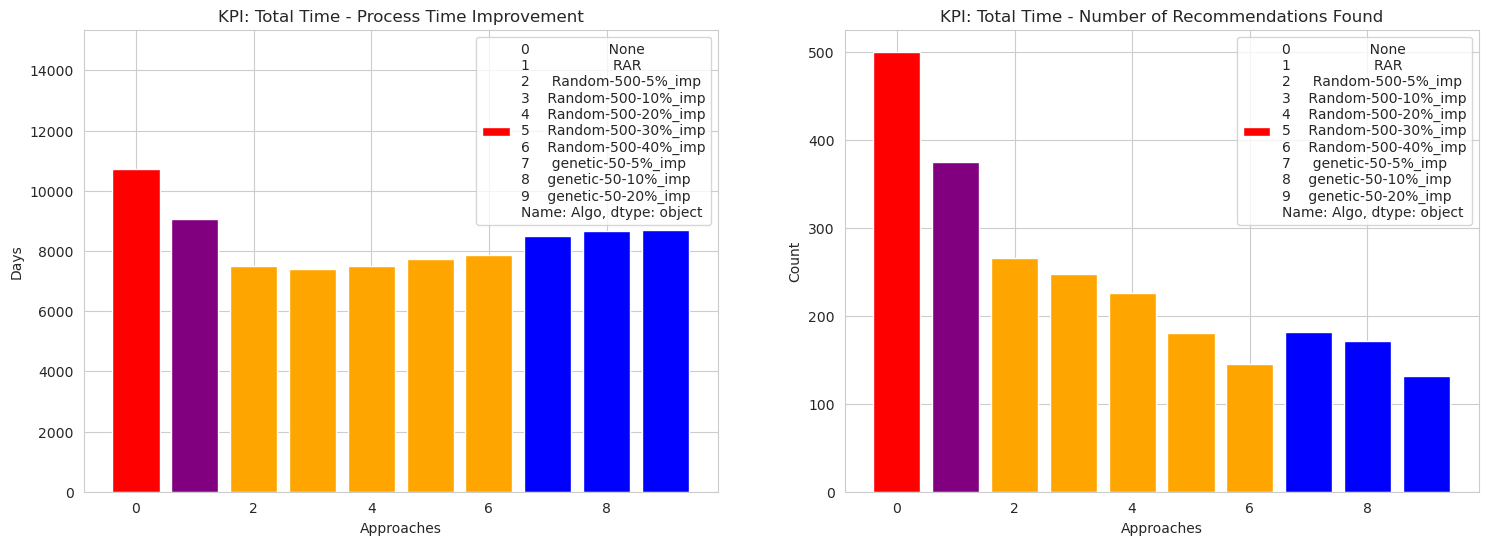

In [112]:
if KPI == "total_time":
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

    axes[0].bar( x=range(len(df_time_kpi)), height=df_time_kpi["time_days"], label=df_time_kpi["Algo"], color=df_time_kpi["colors"] )
    axes[0].set_title('KPI: Total Time - Process Time Improvement')  # TOtal
    axes[0].set_xlabel('Approaches')
    axes[0].set_ylabel('Days');  axes[0].set_ylim(0, 15_350)
    axes[0].legend(loc='upper right')

    axes[1].bar( x=range(len(df_time_kpi)), height=df_time_kpi["score"], label=df_time_kpi["Algo"], color=df_time_kpi["colors"] )
    axes[1].set_title('KPI: Total Time - Number of Recommendations Found')
    axes[1].set_xlabel('Approaches')
    axes[1].set_ylabel('Count');  # axes[1].set_ylim(0, 55)
    axes[1].legend(loc='upper right')

In [134]:
if KPI == "activity_occurrence":
    score_plot = []
    columns = ["Algo", "Count"]

    score_plot.append( ("None", len(test_cases)) )

    # Returns the number of recommendations found by Resource Aware Recommender System (RAR)
    cfe_count = sum( ~df_rar["Activity_recommended"].isna() )
    score_plot.append( ("RAR", cfe_count))

    state_obj = load_experiment("random-a23")
    _, cfe_count = get_cfe_info_test_cases(test_cases, state_obj)
    score_plot.append( ("Random-500", cfe_count) )

    state_obj = load_experiment("random-a24")
    _, cfe_count = get_cfe_info_test_cases(test_cases, state_obj)
    score_plot.append( ("Random-1000", cfe_count) )

    state_obj = load_experiment("genetic-a23")
    _, cfe_count = get_cfe_info_test_cases(test_cases, state_obj)
    score_plot.append( ("Genetic-50", cfe_count) )

    state_obj = load_experiment("genetic-a37")
    _, cfe_count = get_cfe_info_test_cases(test_cases, state_obj)
    score_plot.append( ("Genetic-150", cfe_count) )

    state_obj = load_experiment("genetic-a41")
    _, cfe_count = get_cfe_info_test_cases(test_cases, state_obj)
    score_plot.append( ("Genetic-250", cfe_count) )

    df_activity = pd.DataFrame(score_plot, columns=columns)
    df_activity["colors"] = ['red', 'purple'] + ['orange'] * 2 + ['blue'] * 3  # green
    df_activity

File already exists
File already exists
File already exists
File already exists
File already exists


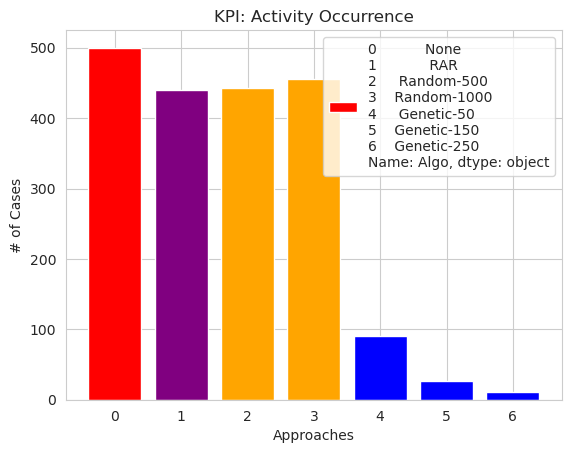

In [140]:
if KPI == "activity_occurrence":
    plt.bar( x=range(len(df_activity)), height=df_activity["Count"], label=df_activity["Algo"], color=df_activity["colors"] )
    plt.title('KPI: Activity Occurrence')
    plt.xlabel('Approaches')
    plt.ylabel('# of Cases');  # plt.ylim(0, 700)
    plt.legend(loc='upper right')

## Plot Results

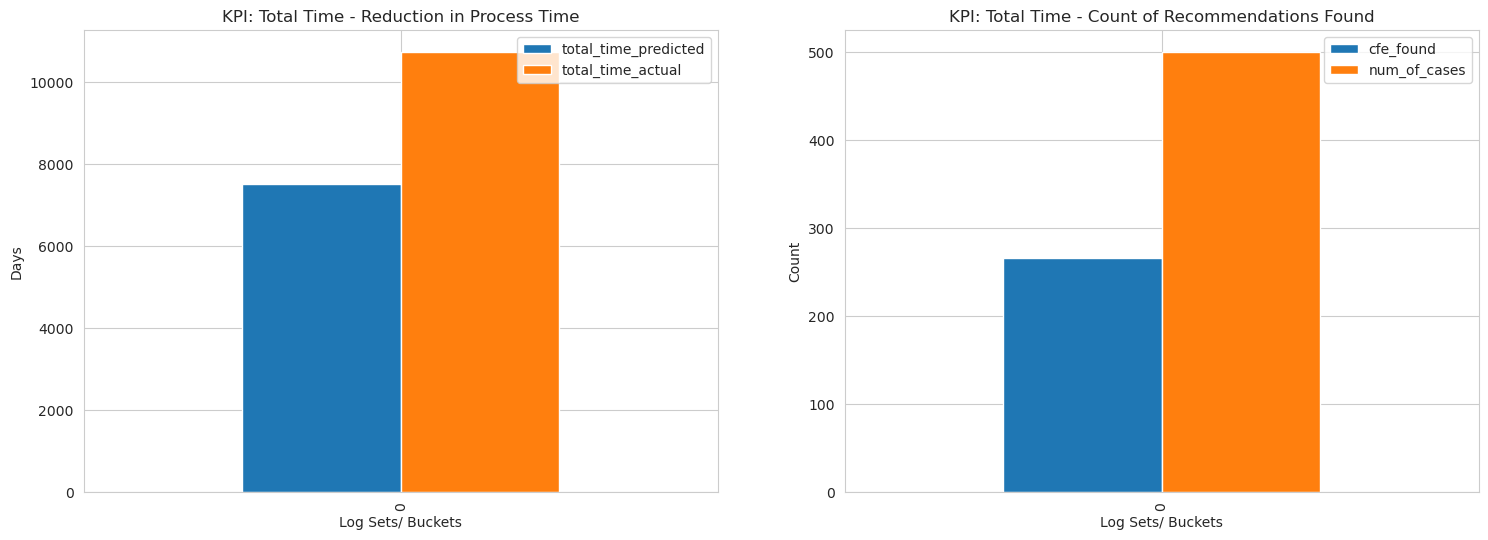

In [14]:
if KPI == "total_time":
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

    df_time[["total_time_predicted", "total_time_actual"]].plot(kind='bar', ax=axes[0])
    axes[0].set_title('KPI: Total Time - Reduction in Process Time')  # TOtal
    axes[0].set_xlabel('Log Sets/ Buckets')
    axes[0].set_ylabel('Days');  # axes[0].set_ylim(0, 1_350)
    axes[0].legend(loc='upper right')

    df_time[["cfe_found", "num_of_cases"]].plot(kind='bar', ax=axes[1])
    axes[1].set_title('KPI: Total Time - Count of Recommendations Found')
    axes[1].set_xlabel('Log Sets/ Buckets')
    axes[1].set_ylabel('Count');  # axes[1].set_ylim(0, 55)
    axes[1].legend(loc='upper right')

KeyError: "['RAR_time_pred'] not in index"

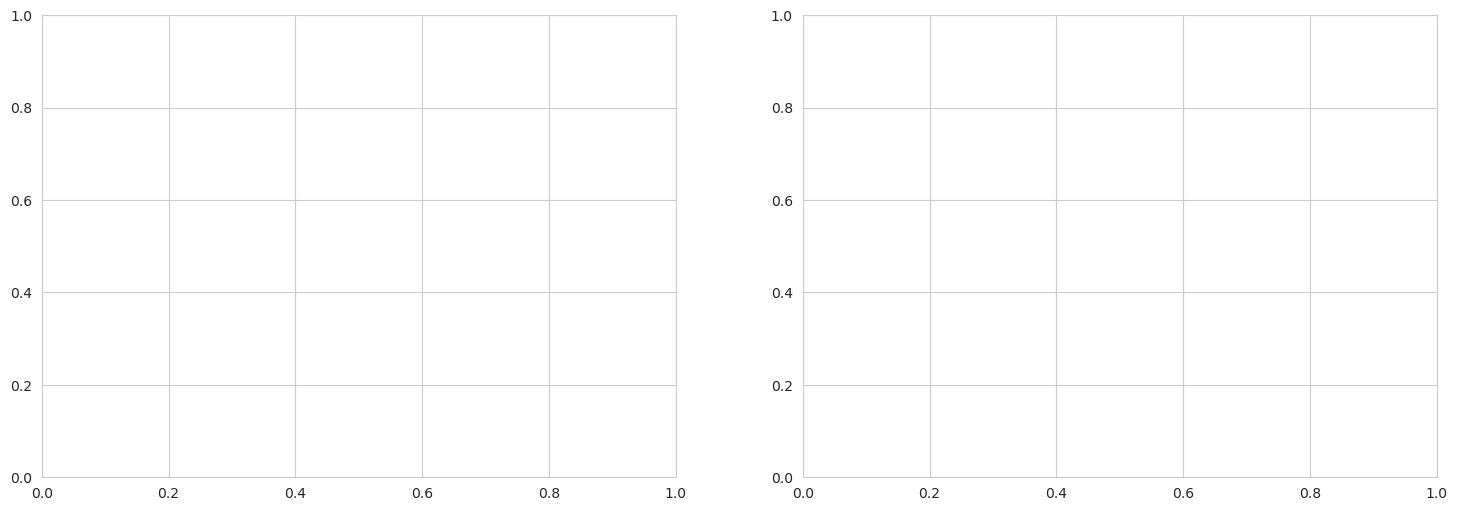

In [11]:
if KPI == "total_time":
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

    df_time[["total_time_predicted", "total_time_actual", "RAR_time_pred"]].plot(kind='bar', ax=axes[0])

    axes[0].set_title('KPI: Total Time - Reduction in Process Time')  # TOtal
    axes[0].set_xlabel('Log Sets/ Buckets')
    axes[0].set_ylabel('Days'); axes[0].set_ylim(0, 1_350)
    axes[0].legend(loc='upper right')

    df_time[["cfe_found", "num_of_cases", "RARs_found"]].plot(kind='bar', ax=axes[1])
    axes[1].set_title('KPI: Total Time - Count of Recommendations Found')
    axes[1].set_xlabel('Log Sets/ Buckets')
    axes[1].set_ylabel('Count'); axes[1].set_ylim(0, 55)
    axes[1].legend(loc='upper right')


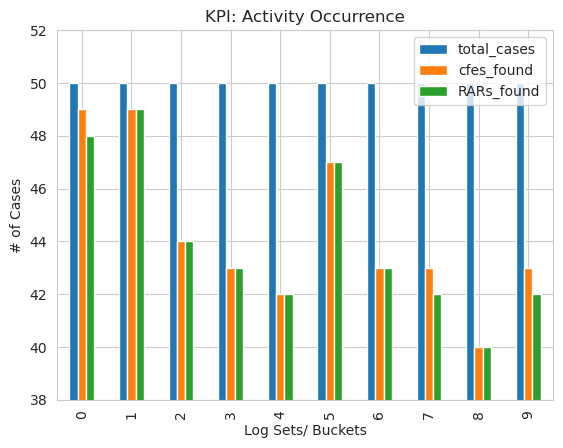

In [164]:
if KPI == "activity_occurrence":
    df[["total_cases", "cfes_found", "RARs_found"]].plot(kind='bar')

    plt.title('KPI: Activity Occurrence')
    plt.xlabel('Log Sets/ Buckets')
    plt.ylabel('# of Cases'); plt.ylim(38, 52)
    plt.legend(loc='upper right')

## Generate a CSV with all the CFEs for the test_cases
Used to send recommendations results to Alessandro

In [39]:
state_obj = load_experiment("genetic-a45")
test_cases_n_cfes, cfe_count = get_cfe_info_test_cases(test_cases, state_obj)

df_test_cases_cfes = pd.DataFrame(columns=df_test.columns)

for case_id, value  in test_cases_n_cfes:
    if isinstance(value, pd.DataFrame):
        # Get the lowest value of lead_time from all CFEs
        if KPI == "total_time":
            cfe = value.loc[ [value["lead_time"].idxmin()] ]  # .loc[ [] ] returns a dataframe with a single row
        else:
            cfe = value.loc[ [0] ]
        cfe[case_id_name] = case_id
        df_test_cases_cfes = pd.concat([df_test_cases_cfes, cfe], axis="rows")

if KPI == "total_time":
    # I manually name the .csv based on the experiment conditions used to generate the CFEs
    df_test_cases_cfes.to_csv(f"{results_dir}/vinst_tt_kpi-improve-5_genetic-50_recommendations.csv", index=False)
else:
    df_test_cases_cfes.to_csv(f"{results_dir}/bac_ao_genetic-50_recommendations.csv", index=False)


successful


In [40]:
df_test_cases_cfes

,REQUEST_ID,START_DATE,CLOSURE_TYPE,CLOSURE_REASON,ACTIVITY,END_DATE,CE_UO,ROLE,time_from_first,time_from_previous_et,time_from_midnight,weekday,activity_duration,time_remaining,# ACTIVITY=Service closure Request with network responsibility,# ACTIVITY=Service closure Request with BO responsibility,# ACTIVITY=Pending Request for Reservation Closure,# ACTIVITY=Pending Liquidation Request,# ACTIVITY=Request completed with account closure,# ACTIVITY=Request created,# ACTIVITY=Authorization Requested,# ACTIVITY=Evaluating Request (NO registered letter),# ACTIVITY=Network Adjustment Requested,# ACTIVITY=Pending Request for acquittance of heirs,# ACTIVITY=Request deleted,# ACTIVITY=Back-Office Adjustment Requested,# ACTIVITY=Evaluating Request (WITH registered letter),# ACTIVITY=Request completed with customer recovery,# ACTIVITY=Pending Request for Network Information,Back-Office Adjustment Requested
0,20187003387,NaN,Client Recess,1 - Client lost,Pending Liquidation Request,NaN,BOC,BACK-OFFICE,16084273.0,183.0,45771.0,Monday,138046.0,NaN,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
0,20191000404,NaN,Client Recess,7 - Keep other relationships. Same dip,Pending Liquidation Request,NaN,BOC,BACK-OFFICE,1038201.0,68.0,44346.0,Monday,140452.0,NaN,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
0,20191001476,NaN,Client Recess,2 - Keep bank account. Same dip,Pending Request for Reservation Closure,NaN,BOC,BACK-OFFICE,943498.0,943076.0,45728.0,Monday,84.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
0,20191001603,NaN,Bank Recess,1 - Client lost,Pending Request for Reservation Closure,NaN,BOC,BACK-OFFICE,683181.0,622609.0,50982.0,Friday,116.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
0,20191001605,NaN,Bank Recess,1 - Client lost,Pending Liquidation Request,NaN,BOC,BACK-OFFICE,952050.0,205.0,61377.0,Monday,123756.0,NaN,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
0,20191002015,NaN,Bank Recess,1 - Client lost,Pending Liquidation Request,NaN,BOC,BACK-OFFICE,857161.0,174.0,37859.0,Monday,147388.0,NaN,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
0,20191002057,NaN,Client Recess,1 - Client lost,Pending Liquidation Request,NaN,BOC,BACK-OFFICE,955788.0,100.0,52262.0,Tuesday,132941.0,NaN,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
0,20191002525,NaN,Bank Recess,1 - Client lost,Service closure Request with BO responsibility,NaN,BOC,BACK-OFFICE,5363.0,5220.0,46167.0,Monday,363003.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
0,20191002543,NaN,Client Recess,1 - Client lost,Service closure Request with BO responsibility,NaN,BOC,BACK-OFFICE,924.0,507.0,42443.0,Monday,685216.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
0,20191002547,NaN,Bank Recess,1 - Client lost,Pending Liquidation Request,NaN,BOC,BACK-OFFICE,355596.0,158.0,51342.0,Friday,306700.0,NaN,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Debug: Check Cases Individually

In [141]:
def df_lead_time_to_days(df):
    ndf = df.copy()
    ndf["lead_time"] = ndf["lead_time"] // SECONDS_TO_DAYS
    return ndf

In [101]:
rar_time_predicted = []
outcome_name = "lead_time"
agg_time = 0
for i, row in df_rar.iterrows(): # To convert row to a dataframe use row.to_frame().T

    if not pd.isna( row["Activity_recommended"] ): # If recommendation exists use that
        # print(f"Case iD: {row[case_id_name]}, Using Predicted time", )
        X_test, y_test = prepare_df_for_ml(test_cases[i], case_id_name, outcome_name, columns_to_remove=["Change_Date+Time", "time_remaining"])
        # Access the last row of the truncated trace to replicate the behavior of a running trace
        query_instance = X_test.iloc[-1:]

        # Add the Recommended action and resource to the query_instance
        query_instance[activity_column_name] = row["Activity_recommended"]
        query_instance[resource_column_name] = row["Resource"]

        # display(query_instance)
        agg_time += model.predict(query_instance)[0]
        # print("Model Predicted Time:", model.predict(query_instance)[0] // SECONDS_TO_DAYS)

        # Check if recommendation makes the expected time worse
        # if model.predict(query_instance)[0] > lowest_lead_time(df_test, row[case_id_name]):
        print(f"Loop: {i}, Case iD: {row[case_id_name]}, Using Predicted time", )
        print("Model Predicted Time:", model.predict(query_instance)[0] // SECONDS_TO_DAYS)
        print("Actual Time:", lowest_lead_time(df_test, row[case_id_name]) // SECONDS_TO_DAYS)

    else:  # Use the Actual Time
        # print(f"Using actual time")
        agg_time += lowest_lead_time(df_test, row[case_id_name])
        # display( df_lead_time_to_days( df_test.loc[df_test[case_id_name] == row[case_id_name]].iloc[-1:] ) )

    # After BUCKET_SIZE elements add the agg_time to the rar_time_predicted,
    if (i+1) % BUCKET_SIZE == 0:  # Cuz indexing starts from 0 so.
        print( "Time is takes for the 1st bucket/ Log Set:", agg_time // SECONDS_TO_DAYS )
        # agg_time = 0
        break

    # if i == 2:
    #     break

Loop: 0, Case iD: 1-729659065, Using Predicted time
Model Predicted Time: 15.0
Actual Time: 18
Loop: 1, Case iD: 1-728288484, Using Predicted time
Model Predicted Time: 9.0
Actual Time: 24
Loop: 2, Case iD: 1-729823831, Using Predicted time
Model Predicted Time: 115.0
Actual Time: 28
Loop: 3, Case iD: 1-740801731, Using Predicted time
Model Predicted Time: 7.0
Actual Time: 10
Loop: 4, Case iD: 1-738897198, Using Predicted time
Model Predicted Time: 23.0
Actual Time: 12
Loop: 5, Case iD: 1-738274604, Using Predicted time
Model Predicted Time: 21.0
Actual Time: 6
Loop: 6, Case iD: 1-740842422, Using Predicted time
Model Predicted Time: 7.0
Actual Time: 7
Loop: 7, Case iD: 1-717431477, Using Predicted time
Model Predicted Time: 8.0
Actual Time: 32
Loop: 8, Case iD: 1-685098751, Using Predicted time
Model Predicted Time: 6.0
Actual Time: 78
Loop: 9, Case iD: 1-736499691, Using Predicted time
Model Predicted Time: 8.0
Actual Time: 18
Loop: 10, Case iD: 1-740596231, Using Predicted time
Mode

In [103]:
agg_time // SECONDS_TO_DAYS

6670.0

In [81]:
predicted_time_rar(df_rar, outcome_name="lead_time", columns_to_remove=["Change_Date+Time", "time_remaining"])
# predicted_time_dice("random-t33")


ValueError: Can only compare identically-labeled Series objects

In [78]:
actual_time_test_cases(test_cases, df_test)

(10728, 500)

In [79]:
# === Code for bucket style time agg on random-t33
rar_time_predicted = []
outcome_name = "lead_time"
agg_time = 0
state_obj = load_experiment("random-t33")

test_cases_n_cfes, cfe_count = get_cfe_info_test_cases(test_cases, state_obj)

total_time = 0
i = 0
for case_id, cfe_info in test_cases_n_cfes:
    if isinstance(cfe_info, pd.DataFrame):
        # Get the lowest value of lead_time from all CFEs
        total_time += cfe_info["lead_time"].min()
    else:
        total_time += lowest_lead_time(df_test, case_id)  # lowest part doesn't matter now as all the rows of a case have the same lead_time

    # After BUCKET_SIZE elements add the agg_time to the rar_time_predicted,
    if (i+1) % BUCKET_SIZE == 0:  # Cuz indexing starts from 0 so.
        print( "Time is takes for the 1st bucket/ Log Set:", total_time // SECONDS_TO_DAYS )
        # agg_time = 0
        break
    i += 1

total_time

File already exists
Time is takes for the 1st bucket/ Log Set: 669.0


57882357.0

### Inspect Trace from case ID

In [145]:
case_id_to_inspect = "1-733209121"
df_test.loc[df_test[case_id_name] == case_id_to_inspect]

,SR_Number,Change_Date+Time,Status,ACTIVITY,Involved_ST_Function_Div,Involved_Org_line_3,Involved_ST,SR_Latest_Impact,Product,Country,Owner_Country,time_from_first,time_from_previous_et,time_from_midnight,weekday,time_remaining,# ACTIVITY=In Progress,# ACTIVITY=Awaiting Assignment,# ACTIVITY=Resolved,# ACTIVITY=Assigned,# ACTIVITY=Closed,# ACTIVITY=Wait - User,# ACTIVITY=Wait - Implementation,# ACTIVITY=Wait,# ACTIVITY=Wait - Vendor,# ACTIVITY=In Call,# ACTIVITY=Wait - Customer,# ACTIVITY=Unmatched,# ACTIVITY=Cancelled,lead_time
3288,1-733209121,1335446009,Queued,Awaiting Assignment,V3_2,Org line C,G359,Medium,PROD337,se,Sweden,0,0,47609,Thursday,2196639,0,0,0,0,0,0,0,0,0,0,0,0,0,2196639
3289,1-733209121,1335446677,Accepted,In Progress,V3_2,Org line C,G359,Medium,PROD337,se,POLAND,668,668,48277,Thursday,2195971,0,1,0,0,0,0,0,0,0,0,0,0,0,2196639
3290,1-733209121,1335446698,Queued,Awaiting Assignment,A2_4,Org line A2,G105 2nd,Medium,PROD337,se,POLAND,689,21,48298,Thursday,2195950,1,1,0,0,0,0,0,0,0,0,0,0,0,2196639
3291,1-733209121,1335447904,Accepted,In Progress,A2_4,Org line A2,G105 2nd,Medium,PROD337,se,Sweden,1895,1206,49504,Thursday,2194744,1,2,0,0,0,0,0,0,0,0,0,0,0,2196639
3292,1-733209121,1335447951,Accepted,Assigned,A2_4,Org line A2,G105 2nd,Medium,PROD337,se,Sweden,1942,47,49551,Thursday,2194697,2,2,0,0,0,0,0,0,0,0,0,0,0,2196639
3293,1-733209121,1335513109,Accepted,In Progress,A2_4,Org line A2,G105 2nd,Medium,PROD337,se,Sweden,67100,65158,28309,Friday,2129539,2,2,0,1,0,0,0,0,0,0,0,0,0,2196639
3294,1-733209121,1336991517,Completed,Resolved,A2_4,Org line A2,G105 2nd,Medium,PROD337,se,Sweden,1545508,1478408,37917,Monday,651131,3,2,0,1,0,0,0,0,0,0,0,0,0,2196639


# Deprecated Code

In [7]:
# a = [6, 5, 4, 1, 2, 3]
# Ascending
# a = [6, 5, 4, 3, 2, 1]
# Bubble Sort
a = [1, 2, 3, 4, 5, 6]
print(a)
def bubble_sort(a: list) -> list:
    for i in range(len(a)):
        for j in range( 0, len(a) - i - 1):
            if a[j] > a[j + 1]:
                a[j], a[j + 1] = a[j + 1], a[j]
    return a

[1, 2, 3, 4, 5, 6]


In [131]:
num = 14
steps = 0
def calc_steps( num ):
    if num <= 0:
        return 0
    if num % 2 == 0:  # if even
        steps = calc_steps( num // 2 )
    else:  # if odd
        steps = calc_steps( num - 1 )
    return steps + 1

a = calc_steps( num )
print("a is:", a)

a is: 6


In [149]:
i = 1


3